In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
data=pd.read_csv('~\Downloads\daily_data.csv')
data

,datetime,high,low,close,open,volume
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333
...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280


In [3]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    frames =  [macd, signal]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

macd=get_macd(data.close,26,12,9)
macd

,macd,signal
0,0.000000,0.000000
1,115.270655,23.054131
2,217.827657,62.008836
3,300.564708,109.720011
4,502.998982,188.375805
...,...,...
1468,-2136.672368,-1568.284564
1469,-2233.642180,-1701.356087
1470,-2313.071268,-1823.699123
1471,-2257.170852,-1910.393469


In [4]:
def generate_signal_for_macd(df,data):
    datetime=[]
    signal=[]
    current=0
    datetime.append(data.datetime[0])
    signal.append(0)
    for i in range(1,len(df.macd)):
        if(df.macd[i]>=df.signal[i] ):
            datetime.append(data.datetime[i])
            signal.append(1)
        elif(df.macd[i]<=df.signal[i]):
            datetime.append(data.datetime[i])
            signal.append(-1)
        else:
            datetime.append(data.datetime[i])
            signal.append(0)
    a=pd.DataFrame(columns=['datetime','signals'])
    a['datetime']=datetime
    a['signals']=signal
    return a
            
        
        
output=generate_signal_for_macd(macd,data)
output

,datetime,signals
0,2018-01-01,0
1,2018-01-02,1
2,2018-01-03,1
3,2018-01-04,1
4,2018-01-05,1
...,...,...
1468,2022-01-08,-1
1469,2022-01-09,-1
1470,2022-01-10,-1
1471,2022-01-11,-1


In [7]:
def calc_dd(data):
    dd = []

    temp_peak = data[0]

    for i in range(len(data)):
        if data[i] > temp_peak:
            temp_peak = data[i]
        dd.append(((temp_peak - data[i])/temp_peak)*100)
    return dd
def compounding_with_stop_loss(data,output,stop_loss_percent=0.05):
    capital=1000 #this is the initial capital
    portfolio_value=[]
    datetime=[]
    quantity=[] #number of stocks
    current=0
    number_of_stock=0
    stop_loss=0
#     stop_loss_percent=0.05
    entry=[]
    exit=[]
    duration=[]
    signal=[]
    count=0 #stop loss count
    current_value=0 #for trailing stop loss if stop loss has to be updated
    trade_type=[]
    drawdown=[]
    commision_rate=1
    dip=[]
    for i in range(len(output.signals)-1):
        if(capital<0):
            print("Capital wiped")
            break
        datetime.append(data.datetime[i])
        if(current==0):
            if(output.signals[i]==0):
                signal.append(0)
                quantity.append(0)
                portfolio_value.append(capital)
                continue
            elif(output.signals[i]==1):
                signal.append(1)
                trade_type.append('long')
                current_value=capital
                portfolio_value.append(capital)
                current=1
                number_of_stock=(capital/data.close[i])
                quantity.append(number_of_stock)
                stop_loss=(1-stop_loss_percent)*(capital)
                capital=0
                entry.append(i)
            else:
                current_value=capital
                trade_type.append('short')
                signal.append(-1)
                portfolio_value.append(capital)
                current=-1
                number_of_stock=(capital/data.close[i])
                quantity.append(number_of_stock)
                stop_loss=(1+stop_loss_percent)*capital
                capital=2*capital
                entry.append(i)
        elif(current==1):
            if(output.signals[i]==0 or output.signals[i]==1):
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                quantity.append(number_of_stock)
                if(capital<stop_loss):
                    signal.append(-1)
                    count=count+1
                    current=0
                    exit.append(i)
                    x=entry[-1]
#                     lambda1=0 #what is the max drawdown
#                     current_max=data.close[x] #what is the max for the range under consideration
#                     for y in range(x+1,i+1):
#                         if(data.close[y]>current_max):
#                             current_max=data.close[y]
                    
#                         temp=(100*(1-(data.close[y]/current_max)))
#                         if(temp>lambda1):
#                             lambda1=temp
            
                
#                     drawdown.append(lambda1)
                    dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
                    continue
                elif(capital>current_value):
                    signal.append(0)
                    current_value=capital
                    stop_loss=(1-stop_loss_percent)*(current_value)
                    
                else:
                    signal.append(0)
                capital=capital-(number_of_stock*data.close[i])
                
            
                
            else:
                quantity.append(number_of_stock)
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(-1)
                
                current=0
                exit.append(i)
                x=entry[-1]
#                 lambda1=0
#                 current_max=data.close[x]
#                 for y in range(x+1,i+1):
#                     if(data.close[y]>current_max):
#                         current_max=data.close[y]
                    
#                     temp=(100*(1-(data.close[y]/current_max)))
#                     if(temp>lambda1):
#                         lambda1=temp
            
                
#                 drawdown.append(lambda1)
                dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
                number_of_stock=0
                
            
        else:
            quantity.append(number_of_stock)
            if(output.signals[i]==0 or output.signals[i]==-1):
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                if(capital>stop_loss):
                    signal.append(1)
                    count=count+1
                    current=0
                    exit.append(i)
                    x=entry[-1]
#                     lambda1=0
#                     current_max=data.close[x]
#                     for y in range(x+1,i+1):
#                         if(data.close[y]<current_max):
#                             current_max=data.close[y]
                    
#                         temp=(100*((data.close[y]/current_max)-1))
#                         if(temp>lambda1):
#                             lambda1=temp
            
                
#                     drawdown.append(lambda1)
                    dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
                    continue
                elif(capital<current_value):
                    signal.append(0)
                    current_value=capital
                    stop_loss=(1+stop_loss_percent)*(current_value)
                else:
                    signal.append(0)
                capital=capital+(number_of_stock*data.close[i])
            else:
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(1)
                
                current=0
                exit.append(i)
                x=entry[-1]
#                 lambda1=0
#                 current_max=data.close[x]
#                 for y in range(x+1,i+1):
#                     if(data.close[y]>current_max):
#                         current_max=data.close[y]
                    
#                     temp=(100*((data.close[y]/current_max)-1))
#                     if(temp>lambda1):
#                         lambda1=temp
            
                
#                 drawdown.append(lambda1)
                dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
                number_of_stock=0
                          
    a=len(data.datetime)-1
    datetime.append(data.datetime[a])
    quantity.append(number_of_stock)
    if(current==1):
        exit.append(a)
        capital=capital+(number_of_stock*data.close[a])
        signal.append(-1)
        x=entry[-1]
#         lambda1=0
#         current_max=data.close[x]
#         for y in range(x+1,a+1):
#             if(data.close[y]>current_max):
#                 current_max=data.close[y]
                    
#             temp=(100*(1-(data.close[y]/current_max)))
#             if(temp>lambda1):
#                 lambda1=temp
            
                
#         drawdown.append(lambda1)
        dip.append(100*((data.close[x]-np.min(data.close[x:i+1])*number_of_stock))/data.close[x])
    elif(current==-1):
        exit.append(a)
        capital=capital-(number_of_stock*data.close[a])
        signal.append(1)
        x=entry[-1]
#         lambda1=0
#         current_max=data.close[x]
#         for y in range(x+1,a+1):
                
#             if(data.close[y]<current_max):
#                 current_max=data.close[y]
                    
#             temp=(100*((data.close[y]/current_max)-1))
#             if(temp>lambda1):
#                 lambda1=temp
                
            
                
#         drawdown.append(lambda1)
        dip.append(100*(np.max(data.close[x:i+1]-data.close[x])*number_of_stock)/data.close[x])
    else:
        signal.append(0)
    portfolio_value.append(capital)
        
        
    
    to_submit=pd.DataFrame(columns=['datetime'])
    to_submit['datetime']=datetime
    to_submit['signals']=signal
    to_submit['open']=data.open
    
    to_submit['high']=data.high
    to_submit['low']=data.low
    to_submit['close']=data.close
    to_submit['volume']=data.volume
    duration=[]
    returns=[]
    PL_in_dollars=[]
    
    
        
    for i in range(len(entry)):
        duration.append(exit[i]-entry[i])
        returns.append(100*((portfolio_value[exit[i]]/portfolio_value[entry[i]])-1))
        PL_in_dollars.append(portfolio_value[exit[i]]-portfolio_value[entry[i]])
        
    trade_wise=pd.DataFrame(columns=['entry','exit','duration','returns'])
    trade_wise['entry']=entry
    trade_wise['exit']=exit
    trade_wise['duration']=duration
    trade_wise['returns']=returns
    trade_wise['type']=trade_type
#     trade_wise['drawdown']=drawdown
    drawdown=calc_dd(portfolio_value)
    every_day=pd.DataFrame(columns=['datetime','portfolio value','quantity'])
    every_day['datetime']=datetime
    every_day['portfolio value']=portfolio_value
    every_day['quantity']=quantity
    every_day['daily_return'] = every_day['portfolio value'].pct_change()
    every_day['drawdown']=drawdown
    daily_volatility = every_day['daily_return'].std()
    annual_volatility = daily_volatility * math.sqrt(365)
    annual_volatility_negative = every_day[every_day['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
    risk_free_rate = 0.05
    every_day['excess_return'] = (every_day['daily_return'] - risk_free_rate)
    annual_excess_return = (every_day['daily_return'].mean()*365 - risk_free_rate)
    cumulative_excess_return = every_day['excess_return'].sum()
    negative_returns = [r for r in every_day['excess_return'] if r < 0]
    cumulative_volatility = every_day['daily_return'].std()*math.sqrt(365)
    hello=np.std(negative_returns)*math.sqrt(365)
    sharpe_ratio = annual_excess_return / annual_volatility
    sortino_ratio = annual_excess_return / annual_volatility_negative
                  
    profit=[]
    loss=[]
    for i in range(len(entry)):
        if(returns[i]>=0):
            profit.append(returns[i])
        else:
            loss.append(returns[i])
    
    print("Total Closed trades: ",len(entry))
    print("Winning trades: ",(len(profit)))
    print("Losing Trades: ",(len(entry)-len(profit)))
    number_of_stock=(1000/(data.close[0]))
    bench_mark_return=(number_of_stock)*(data.close[len(data.close)-1])
    bench_mark_return=(bench_mark_return-1000)
    print("Benchmark Return: ",bench_mark_return)
    print("WIN rate: ",(100*len(profit))/len(entry) , " %")
    print("Gross Profit: ",np.sum(PL_in_dollars))
    net_profit=(np.sum(PL_in_dollars)-(len(PL_in_dollars)*(commision_rate)))
    print("Net Profit: ",net_profit)
    print("Average Profit: ",net_profit/(len(PL_in_dollars)))
    print("MAX Drawdowns: ", ((np.max(drawdown)))," %")
    print("Largest Win: ", np.max(profit))
    print("Average Win: ",(np.mean(profit)))
    
   
    print("Largest Loss: ",np.min(loss))
    print("Average Loss: ",np.mean(loss))
    print("Maximum Holding Time: ",np.max(duration))
    print("Average Holding Duration: ",((np.sum(duration))/(len(duration))))
    print("Maximum Dip: ",np.max(dip))
    print("Avg. Dip: ",np.mean(dip))
    print("Sharpe Ratio: ",sharpe_ratio)
    
    print("Sortino Ratio: ", sortino_ratio )
    
   
    print("returns: ",(net_profit/10)," %")
                  
    plt.plot(portfolio_value)
    print("Number of times stop loss met: ",count)
    return to_submit,trade_wise,every_day

Total Closed trades:  207
Winning trades:  105
Losing Trades:  102
Benchmark Return:  2248.9531785306435
WIN rate:  50.72463768115942  %
Gross Profit:  8966.625010401438
Net Profit:  8759.625010401438
Average Profit:  42.31702903575574
MAX Drawdowns:  52.934598703382406  %
Largest Win:  57.606406559096214
Average Win:  8.787411072360337
Largest Loss:  -17.560310880829
Average Loss:  -5.825106515652761
Maximum Holding Time:  65
Average Holding Duration:  6.111111111111111
Maximum Dip:  93.62908464063604
Avg. Dip:  30.246974424659005
Sharpe Ratio:  1.0827441551986325
Sortino Ratio:  1.4489058034969333
returns:  875.9625010401438  %
Number of times stop loss met:  129


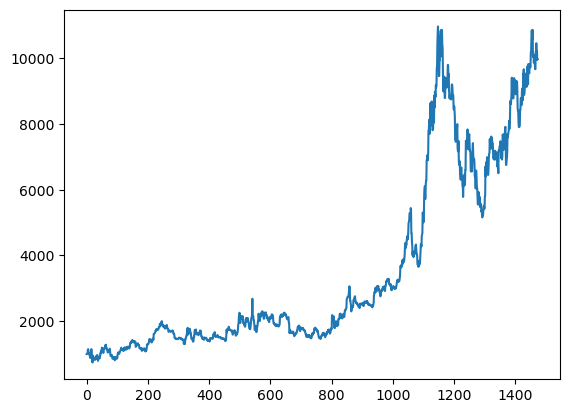

In [8]:
to_submit,trade_wise,every_day=compounding_with_stop_loss(data,output)

In [12]:
to_submit.to_csv(r'C:\Users\tanus\Downloads\macd_signals.csv')

In [10]:
trade_wise

,entry,exit,duration,returns,type
0,1,7,6,2.194787,long
1,8,10,2,-7.714018,long
2,11,13,2,1.046453,short
3,14,15,1,20.500291,short
4,16,20,4,-17.560311,short
...,...,...,...,...,...
202,1443,1448,5,-1.018057,short
203,1449,1457,8,3.294093,long
204,1458,1464,6,-3.747980,long
205,1465,1466,1,5.555062,short


In [11]:
every_day

,datetime,portfolio value,quantity,daily_return,drawdown,excess_return
0,2018-01-01,1000.000000,0.000000,NaN,0.000000,NaN
1,2018-01-02,1000.000000,0.068587,0.000000,0.000000,-0.050000
2,2018-01-03,1011.657750,0.068587,0.011658,0.000000,-0.038342
3,2018-01-04,1015.843621,0.068587,0.004138,0.000000,-0.045862
4,2018-01-05,1137.105624,0.068587,0.119371,0.000000,0.069371
...,...,...,...,...,...,...
1468,2022-01-08,10454.722070,0.244638,0.024643,4.651131,-0.025357
1469,2022-01-09,10139.831237,0.244638,-0.030119,7.522990,-0.080119
1470,2022-01-10,10228.490534,0.244638,0.008744,6.714402,-0.041256
1471,2022-01-11,9947.053962,0.244638,-0.027515,9.281152,-0.077515


In [10]:
macd=pd.read_csv('~\Downloads\Macd+Volty Expan.csv')
macd

,Unnamed: 0,datetime,high,low,close,open,volume,signals
0,0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,0
1,1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,0
2,2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,0
3,3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,0
4,4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,0
...,...,...,...,...,...,...,...,...
1468,1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,0
1469,1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,0
1470,1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,0
1471,1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,0


Total Closed trades:  76
Winning trades:  46
Losing Trades:  30
Benchmark Return:  2248.9531785306435
WIN rate:  60.526315789473685  %
Gross Profit:  17812.083804858274
Net Profit:  17736.083804858274
Average Profit:  233.36952374813518
MAX Drawdowns:  19.703510653063294  %
Largest Win:  52.07002399934506
Average Win:  10.704014258991124
Largest Loss:  -11.756995203248188
Average Loss:  -4.89809337091474
Maximum Holding Time:  49
Average Holding Duration:  9.197368421052632
Maximum Dip:  86.73528806084367
Avg. Dip:  30.497060594853686
Sharpe Ratio:  1.589424895562994
Sortino Ratio:  1.6523790532532416
returns:  1781.208380485827  %
Number of times stop loss met:  66


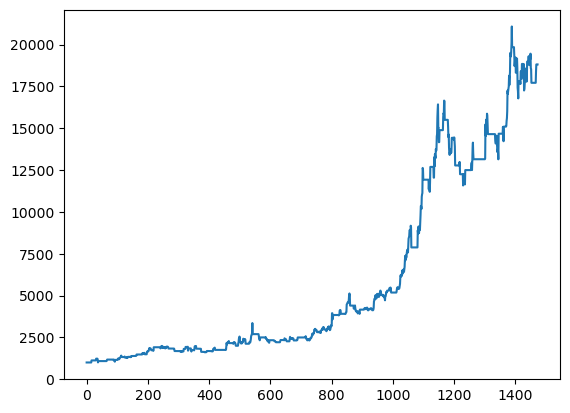

In [11]:
to_submit,trade_wise,every_day=compounding_with_stop_loss(data,macd)

In [20]:
signals=pd.read_csv(r'C:\Users\tanus\Downloads\signals.csv')
signals

,Unnamed: 0,datetime,high,low,close,open,volume,TR,ATR,signals,Upper Channel,Lower Channel
0,0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,NaN,NaN,0,NaN,NaN
1,1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,1859.98,NaN,0,NaN,NaN
2,2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,1323.49,NaN,0,NaN,NaN
3,3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,1361.96,NaN,0,NaN,NaN
4,4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,2518.13,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1468,1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,1745.37,2396.496,0,43076.316,38283.324
1469,1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,1780.00,2340.988,0,44307.978,39626.002
1470,1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,3136.70,2664.328,0,44268.908,38940.252
1471,1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,1941.01,2314.876,0,45069.876,40440.124


STOP LOSS:  0.01
Total Closed trades:  137
Winning trades:  72
Losing Trades:  65
Benchmark Return:  2248.9531785306435
WIN rate:  52.55474452554745  %
Gross Profit:  2881.1247558836485
Net Profit:  2744.1247558836485
Average Profit:  20.030107707179916
MAX Drawdowns:  20.830014034721355  %
Largest Win:  29.165135899010465
Average Win:  5.5640391280075
Largest Loss:  -14.862290478233176
Average Loss:  -3.582102547396495
Maximum Holding Time:  16
Average Holding Duration:  3.102189781021898
Maximum Dip:  94.98948945746383
Avg. Dip:  35.77365841064243
Sharpe Ratio:  0.883341860867074
Sortino Ratio:  0.6926837672901357
returns:  288.1124755883648  %
Number of times stop loss met:  121



STOP LOSS:  0.02
Total Closed trades:  119
Winning trades:  65
Losing Trades:  54
Benchmark Return:  2248.9531785306435
WIN rate:  54.621848739495796  %
Gross Profit:  4999.398691580725
Net Profit:  4880.398691580725
Average Profit:  41.0117537107624
MAX Drawdowns:  20.830014034721355  %
Largest Win:  37.

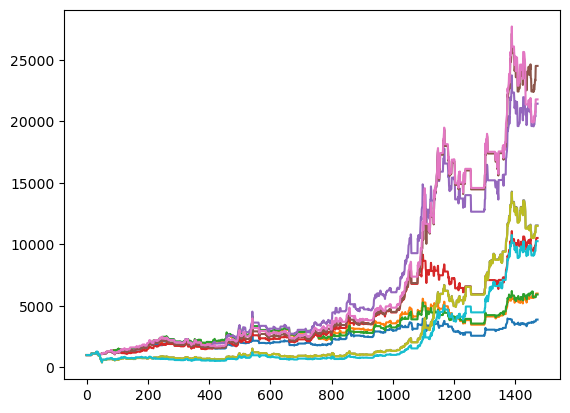

In [17]:
# 1 hour
for i in range(0,10):
    stop_loss_percent=(i+1)/100
        
    print("STOP LOSS: ",stop_loss_percent)
#         print("Take Profit: ",take_profit_percent)
    compounding_with_stop_loss(data,signals,stop_loss_percent)
    print("\n\n")

In [18]:
signals=pd.read_csv(r'C:\Users\tanus\Downloads\Macd+Volty Expan.csv')
signals

,Unnamed: 0,datetime,high,low,close,open,volume,signals
0,0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,0
1,1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,0
2,2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,0
3,3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,0
4,4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,0
...,...,...,...,...,...,...,...,...
1468,1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,0
1469,1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,0
1470,1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,0
1471,1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,0


STOP LOSS:  0.01
Total Closed trades:  111
Winning trades:  65
Losing Trades:  46
Benchmark Return:  2248.9531785306435
WIN rate:  58.55855855855856  %
Gross Profit:  5609.722623299327
Net Profit:  5498.722623299327
Average Profit:  49.53804165134529
MAX Drawdowns:  19.703510653063294  %
Largest Win:  29.165135899010465
Average Win:  5.408246820614544
Largest Loss:  -13.350629365468725
Average Loss:  -3.0132408440971465
Maximum Holding Time:  16
Average Holding Duration:  3.063063063063063
Maximum Dip:  91.31515537240212
Avg. Dip:  35.49233810645017
Sharpe Ratio:  1.2964974334195336
Sortino Ratio:  0.9663526999761145
returns:  560.9722623299327  %
Number of times stop loss met:  109



STOP LOSS:  0.02
Total Closed trades:  97
Winning trades:  61
Losing Trades:  36
Benchmark Return:  2248.9531785306435
WIN rate:  62.88659793814433  %
Gross Profit:  9052.451632606968
Net Profit:  8955.451632606968
Average Profit:  92.32424363512338
MAX Drawdowns:  19.703510653063294  %
Largest Win:  37.

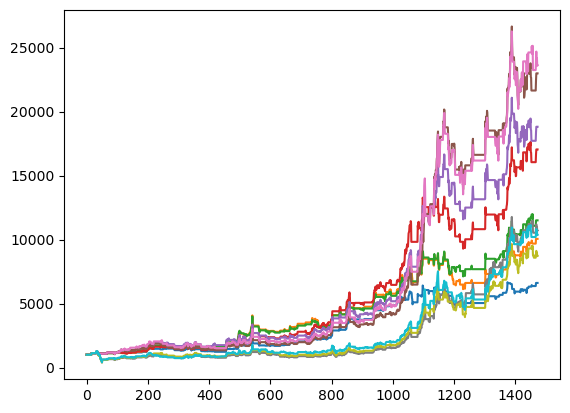

In [19]:
# 1 hour
for i in range(0,10):
    stop_loss_percent=(i+1)/100
        
    print("STOP LOSS: ",stop_loss_percent)
#         print("Take Profit: ",take_profit_percent)
    compounding_with_stop_loss(data,signals,stop_loss_percent)
    print("\n\n")

Total Closed trades:  82
Winning trades:  48
Losing Trades:  34
Benchmark Return:  2248.9531785306435
WIN rate:  58.53658536585366  %
Gross Profit:  23507.964928523983
Net Profit:  23425.964928523983
Average Profit:  285.68249912834125
MAX Drawdowns:  20.830014034721355  %
Largest Win:  85.12614769702789
Average Win:  12.497455117079548
Largest Loss:  -14.862290478233199
Average Loss:  -5.876278677085941
Maximum Holding Time:  50
Average Holding Duration:  9.5
Maximum Dip:  86.7466646236488
Avg. Dip:  31.215248663113837
Sharpe Ratio:  1.621935253292932
Sortino Ratio:  1.7341582856580058
returns:  2350.7964928523984  %
Number of times stop loss met:  47


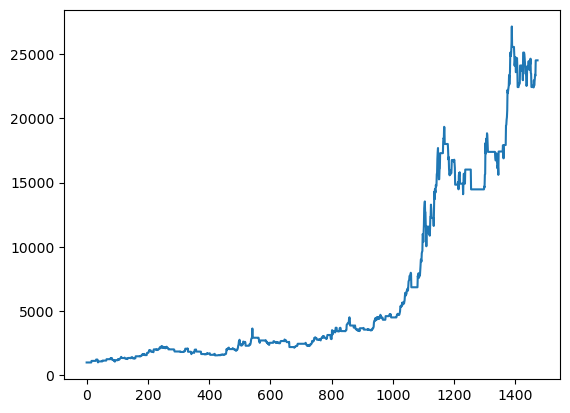

In [22]:
to_submit,trade_wise,every_day=compounding_with_stop_loss(data,signals,0.06)